In [2]:
import dill
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.patches as mpatches
import matplotlib as mpl
# mpl.use("pgf")
# plt.rcParams['pgf.texsystem'] = 'pdflatex'
# plt.rcParams['text.usetex'] = True
# plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['figure.edgecolor'] = 'k'
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.family'] = "serif"

from mycolorpy import colorlist as mcp
from shapely.geometry import Point

In [3]:
sim_path = "../2023-dotson-prelim/data/2022-12-31-USNGA3-results.pkl"
with open(sim_path, "rb+") as file:
    data = dill.load(file)

(0.0, 80.0)

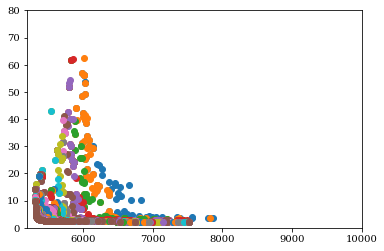

In [4]:
n_pts = 0.0
for i, h in enumerate(data.history):
    if i < 9:
        continue
#         break
    else:
        F_hist = h.pop.get("F")
        n_pts += len(F_hist)
        mask = F_hist < 1e40
        F_hist = np.ma.masked_values(F_hist, 1e40)
        plt.scatter(F_hist[:,0], F_hist[:,1])
plt.xlim(5200,1e4)
plt.ylim(0,80)

In [5]:
n_pts

8600.0

In [6]:
F = data.F
X = data.X
# display(X,F)

In [7]:
df = pd.DataFrame({"Cost":F[:,0], "Carbon":F[:,1]})
slack = 1.1
f1 = F[:,0]*slack
f2 = F[:,1]*slack
df2 = pd.DataFrame({"Cost":f1, "Carbon":f2})
df.sort_values(by="Cost", inplace=True)
df2.sort_values(by="Cost", inplace=True)

In [8]:
a = list(zip(F[:,0],F[:,1]))

In [9]:
b = list(zip(f1,f2))

In [10]:
ab = np.concatenate([a,b],axis=0)

In [11]:
ab = list(zip(np.append(df.sort_values(by="Cost").Cost.values, df2.sort_values(by="Cost").Cost.values[::-1]),
np.append(df.sort_values(by="Cost").Carbon.values, df2.sort_values(by="Cost").Carbon.values[::-1])))

In [12]:
# points = list(ab[ab[:,1].argsort()])
points = list(ab)

In [14]:
from shapely import geometry
from shapely.geometry import Point, Polygon

In [15]:
poly = Polygon(points)

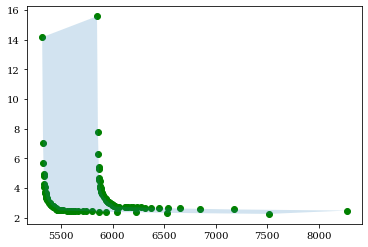

In [16]:
fig, ax = plt.subplots()
ax.scatter(*zip(*points), c='green')
ax.fill(np.append(df.sort_values(by="Cost").Cost.values, df2.sort_values(by="Cost").Cost.values[::-1]),
np.append(df.sort_values(by="Cost").Carbon.values, df2.sort_values(by="Cost").Carbon.values[::-1]), alpha=0.2)

[ 8268.691744829568 15.568493424764664 ]


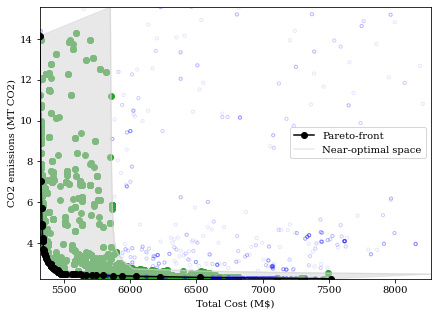

In [15]:
color_1 = 'k'
color_2 = 'lightgrey'
alpha = 0.5

F1_sub = []
F2_sub = []
X_sub = []
print("[",f1.max(), f2.max(),"]")
fig, ax = plt.subplots(figsize=(7,5), facecolor='w')
color_list = mcp.gen_color('jet', n=len(data.history))

for h,c in zip(data.history, color_list):
    F_hist = h.pop.get("F")
    X_hist = h.pop.get("X")
    F_hist_masked = np.ma.masked_values(F_hist, 1e40)
    ax.scatter(F_hist_masked[:, 0], F_hist_masked[:, 1], s=10, facecolors='none', 
                edgecolors='blue', alpha=0.1)
    
    for x,y,z in zip(F_hist[:,0], F_hist[:,1], X_hist):
        if poly.contains(Point(x,y)):
            ax.scatter(x,y,color='tab:green')
            F1_sub.append(x)
            F2_sub.append(y)
            X_sub.append(z)

df.sort_values(by="Cost").plot.line(ax=ax,x='Cost', y='Carbon',legend=False, color=color_1, marker='o', 
                                    label='Pareto-front')
df2.sort_values(by="Cost").plot.line(ax=ax,x='Cost', y='Carbon',legend=False, color=color_2, alpha=alpha,
                                    label='Near-optimal space')

patch = ax.fill(np.append(df.sort_values(by="Cost").Cost.values, df2.sort_values(by="Cost").Cost.values[::-1]),
       np.append(df.sort_values(by="Cost").Carbon.values, df2.sort_values(by="Cost").Carbon.values[::-1]),
       alpha=alpha, color=color_2)

ax.set_xlim(min(F[:,0]),max(F[:,0])*slack)
ax.set_ylim(min(F[:,1]),max(F[:,1])*slack)

plt.xlabel("Total Cost (M$)")
plt.ylabel("CO2 emissions (MT CO2)")
plt.legend()
plt.show()

In [16]:
subopt_df = pd.DataFrame({'Cost':F1_sub, 'Carbon':F2_sub, 'Designs':X_sub})
subopt_df.head()

,Cost,Carbon,Designs
0,5862.559637,5.879759,"[0.6285264702450225, 0.04825692340121242, 0.06..."
1,6100.994873,2.671806,"[0.6327077774633276, 0.07693995812472318, 0.0,..."
2,5916.958743,3.027023,"[0.5447908109793637, 0.04588218237900135, 0.0,..."
3,5862.559637,5.879759,"[0.6285264702450226, 0.04825692340121242, 0.06..."
4,5862.559637,5.879759,"[0.6285264702450225, 0.04825692340121242, 0.06..."


[ 8268.691744829568 15.568493424764664 ]


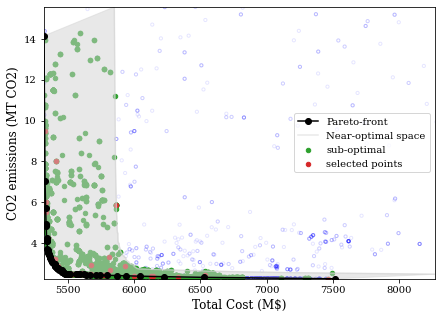

In [23]:
color_1 = 'k'
color_2 = 'lightgrey'
alpha = 0.5
N_solutions = 31
np.random.seed(1234)

F1_sub = []
F2_sub = []
print("[",f1.max(), f2.max(),"]")
fig, ax = plt.subplots(figsize=(7,5), facecolor='w')
color_list = mcp.gen_color('jet', n=len(data.history))

labeled = True
for i,(h,c) in enumerate(zip(data.history, color_list)):
    
#     if (i < 5) or (i > 12):
    if i > 1000:
        continue
    else:
        F_hist = h.pop.get("F")
        X_hist = h.pop.get("X")
        F_hist_masked = np.ma.masked_values(F_hist, 1e40)
        if labeled:
            ax.scatter(F_hist_masked[:, 0], F_hist_masked[:, 1], s=10, facecolors='none', 
                        edgecolors='blue', alpha=0.1)
        else:
            ax.scatter(F_hist_masked[:, 0], F_hist_masked[:, 1], s=10, facecolors='none', 
                        edgecolors='blue', alpha=0.1, label='excluded point')
            labeled = True

subopt_df.plot.scatter(ax=ax, x='Cost', y='Carbon', legend=True, 
                       color='tab:green', marker='o', label='sub-optimal')

X_select = np.zeros((10,N_solutions)).T
for n in range(N_solutions):
    loc = np.random.randint(len(subopt_df))
    if n == 0:
        subopt_df.loc[[loc]].plot.scatter(ax=ax, x='Cost', y='Carbon',
                                          color='tab:red', marker='o', label='selected points')
    else:
        subopt_df.loc[[loc]].plot.scatter(ax=ax, x='Cost', y='Carbon', legend=False,
                                          color='tab:red', marker='o', label='sub-optimal')
    
    X_select[n] = subopt_df.loc[loc, 'Designs']

df.sort_values(by="Cost").plot.line(ax=ax,x='Cost', y='Carbon',legend=False, color=color_1, marker='o', 
                                    label='Pareto-front')
df2.sort_values(by="Cost").plot.line(ax=ax,x='Cost', y='Carbon',legend=False, color=color_2, alpha=alpha,
                                    label='Near-optimal space')

patch = ax.fill(np.append(df.sort_values(by="Cost").Cost.values, df2.sort_values(by="Cost").Cost.values[::-1]),
       np.append(df.sort_values(by="Cost").Carbon.values, df2.sort_values(by="Cost").Carbon.values[::-1]),
       alpha=alpha, color=color_2)

ax.set_xlim(min(F[:,0]),max(F[:,0])*slack)
ax.set_ylim(min(F[:,1]),max(F[:,1])*slack)

plt.xlabel("Total Cost (M\$)", fontsize=12)
plt.ylabel("CO2 emissions (MT CO2)", fontsize=12)
plt.legend()
# plt.savefig("../2023-dotson-prelim/docs/figures/osier_mga_subset_01.png")
plt.show()

In [18]:
with open('../2023-dotson-prelim/data/2022-12-31-optimal_objective_F.pkl', "rb") as file:
    osier_F = dill.load(file)
with open('../2023-dotson-prelim/data/2022-12-31-optimal_design_X.pkl', "rb") as file:
    osier_X = dill.load(file)
with open('../2023-dotson-prelim/data/2022-11-18-temoa_mga_objective.pkl', "rb") as file:
    temoa_F = dill.load(file)
with open('../2023-dotson-prelim/data/2022-11-18-temoa-mga-design.pkl', "rb") as file:
    temoa_X = dill.load(file)
with open('../2023-dotson-prelim/data/2022-12-31-techset.pkl', "rb") as file:
    techs = dill.load(file)

labels = [t.technology_name for t in techs]

In [21]:
peak_demand = 29.251353638620195

In [22]:
X_select.shape

(31, 10)

In [28]:
hex_colors = []
for c in plt.cm.tab10.colors:
    hex_colors.append(mpl.colors.to_hex(c))

<ipython-input-35-1f7dee8de91b>:56: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


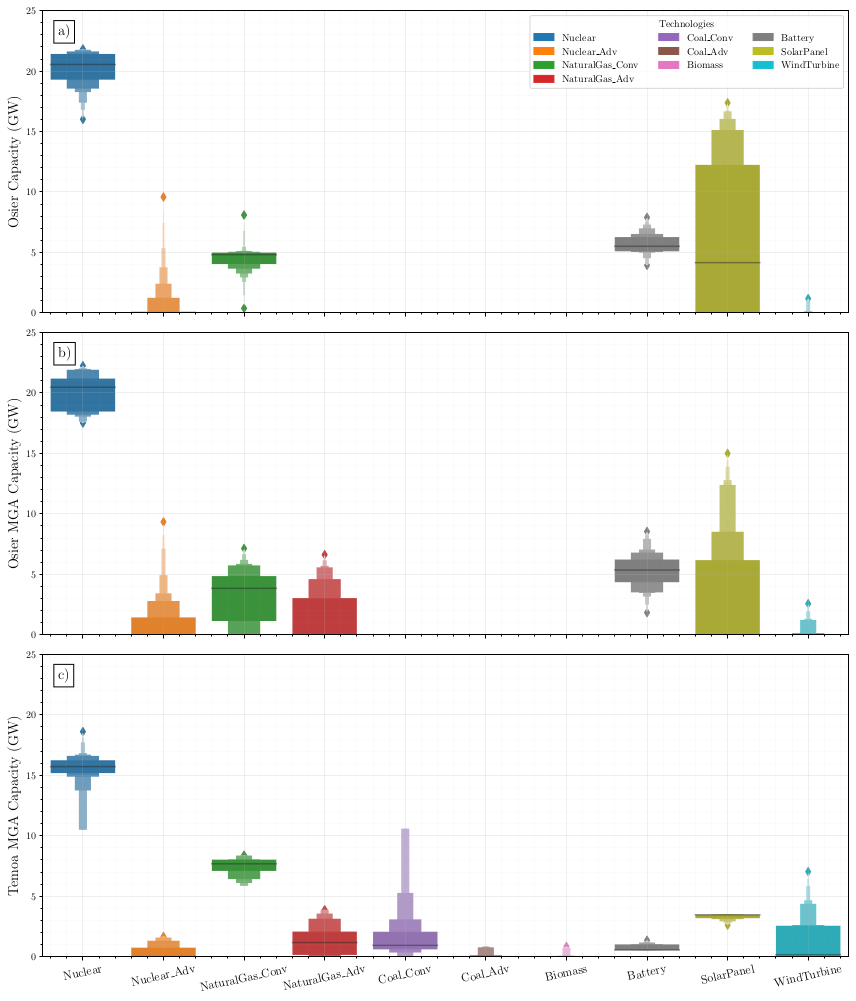

In [35]:
fig, axes = plt.subplots(3,1,figsize=(12,14), facecolor='w', sharex=True, sharey=True)
sb.boxenplot(ax=axes[0], data=(osier_X)*peak_demand)
sb.boxenplot(ax=axes[1], data=(X_select)*peak_demand)
sb.boxenplot(ax=axes[2], data=(temoa_X))
# axes[0].scatter(labels, osier_cost_opt, color='k')
# axes[1].scatter(labels, temoa_cost_opt, color='k')
axes[0].minorticks_on()
axes[1].minorticks_on()
axes[2].minorticks_on()
axes[0].set_ylabel('Osier Capacity (GW)', size=14)
axes[1].set_ylabel('Osier MGA Capacity (GW)', size=14)
axes[2].set_ylabel('Temoa MGA Capacity (GW)', size=14)
# axes[1].set_ylim(0, 30)
axes[0].grid(alpha=0.2, which='major')
axes[0].grid(alpha=0.05, which='minor')
axes[1].grid(alpha=0.2, which='major')
axes[2].grid(alpha=0.2, which='major')
axes[1].grid(alpha=0.05, which='minor')
axes[2].grid(alpha=0.05, which='minor')
axes[0].set_ylim(0,25)
axes[1].set_ylim(0,25)
axes[2].set_ylim(0,25)


# sb.barplot(ax=axes[2], data=opt_df, x='Techs', y='Capacity', hue='Objective', palette='Paired')
# sb.barplot(ax=ax, x=labels, y=temoa_cost_opt)
# sb.barplot(ax=ax, x=labels, y=osier_cost_opt)
axes[2].set_xticklabels(labels, rotation=12.5, size=12)
axes[2].set_xticks(range(len(labels)))
# axes[2].set_ylabel("Capacity (GW)", size=14)
axes[2].set_xlabel("", size=14)

x_loc, y_loc = -.31, 22.95
axes[0].text(x_loc,y_loc, "a)", fontsize=14, bbox=dict({'facecolor':'w'}))
axes[1].text(x_loc,y_loc, "b)", fontsize=14, bbox=dict({'facecolor':'w'}))
axes[2].text(x_loc,y_loc, "c)", fontsize=14, bbox=dict({'facecolor':'w'}))

patch = mpatches.Patch(color='grey', label='manual patch')
patches = []
for color, label in zip(hex_colors, labels):
    patches.append(mpatches.Patch(color=color, label=label))

handles, llabels = axes[0].get_legend_handles_labels()
handles.extend(patches)
# print(handles, llabels)

axes[0].legend(handles=handles, ncol=3, title='Technologies')
# axes[1].legend(handles=handles, ncol=4)
# axes[2].legend(ncol=3, title='Objectives')

plt.tight_layout()


# plt.savefig("../2023-dotson-prelim/docs/figures/temoa_osier_mga_comparison1x3.pgf")

plt.show()